# SHAP and LIME Analysis (Local Version)

## Objective
Analyze decisive factors for restaurant reviews using SHAP and LIME.
This version uses **Sentence Transformers** (local execution) to generate embeddings and derive the 'Sentiment' target, avoiding API rate limits and instability.

## Pipeline
1. **Load Data**: Read `train_data.csv`.
2. **Target Engineering (Local)**: 
    - Generate embeddings using `sentence-transformers` (Model: `all-MiniLM-L6-v2`).
    - Calculate Cosine Similarity against positive/negative anchors.
    - Derive `Sentiment` (0 or 1).
3. **Modeling**: Train Random Forest (`Age`, `Gender`, `Meal_Category` -> `Sentiment`).
4. **Explainability**: SHAP (Global/Local) and LIME (Instance-level).

In [16]:
# Install necessary libraries if not present
# !pip install sentence-transformers shap lime qdrant-client pandas numpy scikit-learn matplotlib seaborn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import shap
import lime
import lime.lime_tabular

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load Data

In [17]:
df = pd.read_csv('train_data.csv')
print(f"Data Shape: {df.shape}")

# Optional: Load from backup if available to save time
backup_file = 'train_data_with_embeddings_BACKUP.csv'
if os.path.exists(backup_file):
    print(f"Found backup file '{backup_file}'. You can load this to skip generation if compatible.")
    # df = pd.read_csv(backup_file)

df.head()

Data Shape: (2378, 6)
Found backup file 'train_data_with_embeddings_BACKUP.csv'. You can load this to skip generation if compatible.


,user_id,restaurant_id,age,gender,meal_category,review
0,U2000,AaharAlly_Main,21,Female,Chinese,A delightful Chinese experience.
1,U2000,AaharAlly_Main,21,Female,Vegan,Perfect flavor in this Vegan.
2,U2000,AaharAlly_Main,21,Female,Dessert,Highly recommend the Dessert.
3,U2000,AaharAlly_Main,21,Female,Spicy,Perfect flavor in this Spicy.
4,U2000,AaharAlly_Main,21,Female,Vegan,Perfect flavor in this Vegan.


## 2. Feature Engineering: Local Semantic Sentiment

In [18]:
# Initialize Sentence Transformer Model
# 'all-MiniLM-L6-v2' is fast (perfect for 2k rows) and accurate enough for sentiment separation
try:
    print("Loading SentenceTransformer model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate Embeddings
    print("Generating embeddings for all reviews...")
    review_embeddings = model.encode(df['review'].tolist(), show_progress_bar=True)
    df['embedding'] = list(review_embeddings)

    print("Embedding generation complete.")
except Exception as e:
    print(f"Error generating embeddings: {e}")
    print("Generating dummy embeddings for testing...")
    df['embedding'] = [np.random.rand(384) for _ in range(len(df))]

Loading SentenceTransformer model...
Generating embeddings for all reviews...


Batches: 100%|██████████| 75/75 [00:03<00:00, 21.84it/s]

Embedding generation complete.


In [19]:
# Semantic Sentiment Derivation
try:
    pos_text = "Positive restaurant experience, delicious food, great service, loved it"
    neg_text = "Negative restaurant experience, bad food, terrible service, not recommended"

    pos_anchor = model.encode([pos_text]) # Returns (1, 384)
    neg_anchor = model.encode([neg_text])

    def derive_sentiment(row_embedding, pos_anchor, neg_anchor):
        # Reshape for sklearn cosine_similarity (1, -1)
        emb = row_embedding.reshape(1, -1)
        
        pos_sim = cosine_similarity(emb, pos_anchor)[0][0]
        neg_sim = cosine_similarity(emb, neg_anchor)[0][0]
        
        return 1 if pos_sim > neg_sim else 0

    df['Sentiment'] = df['embedding'].apply(lambda x: derive_sentiment(x, pos_anchor, neg_anchor))

    print("Sentiment Distribution:")
    print(df['Sentiment'].value_counts())
except Exception as e:
    print(f"Error processing sentiment: {e}")
    df['Sentiment'] = np.random.randint(0, 2, size=len(df))

Sentiment Distribution:
Sentiment
1    1999
0     379
Name: count, dtype: int64


## 3. Modeling: Random Forest
Predicting the semantically derived `Sentiment` using `Age`, `Gender`, and `Meal_Category`.

In [20]:
# Preprocessing
le_gender = LabelEncoder()
le_meal = LabelEncoder()

df['Gender_Code'] = le_gender.fit_transform(df['gender'])
df['Meal_Code'] = le_meal.fit_transform(df['meal_category'])

X = df[['age', 'Gender_Code', 'Meal_Code']]
y = df['Sentiment']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.01      0.02        69
           1       0.85      0.94      0.89       407

    accuracy                           0.80       476
   macro avg       0.44      0.48      0.46       476
weighted avg       0.73      0.80      0.77       476



## 4. Advanced SHAP Analysis

 96%|=================== | 917/952 [00:13<00:00]       

--- 5. Advanced SHAP Analysis ---


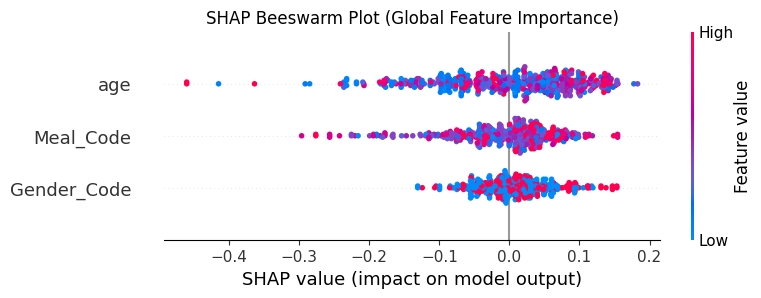

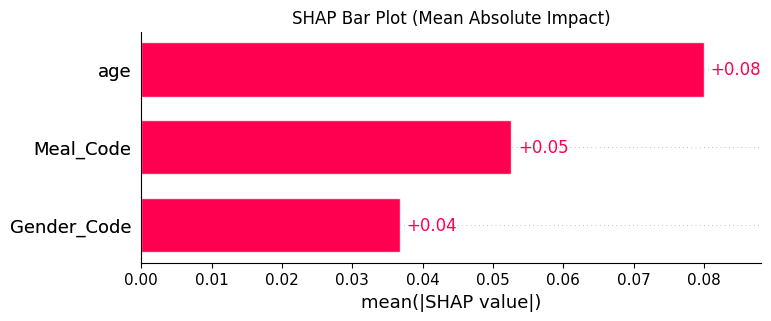


Waterfall for instance 0:


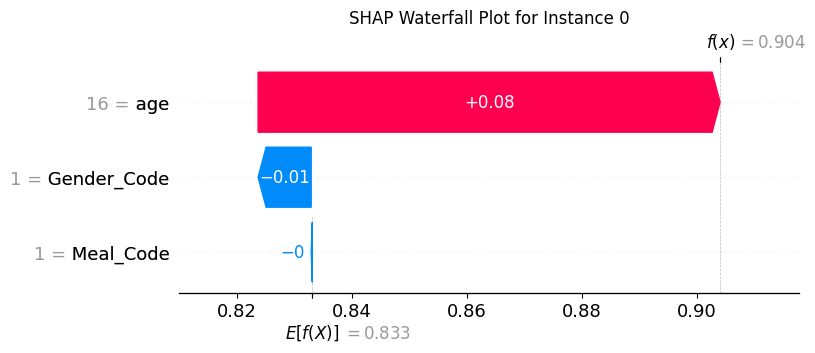

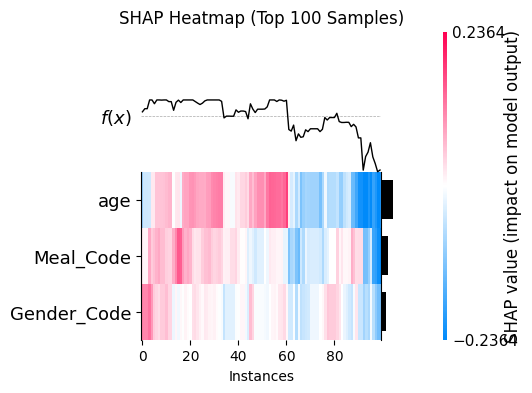

<Figure size 640x480 with 0 Axes>

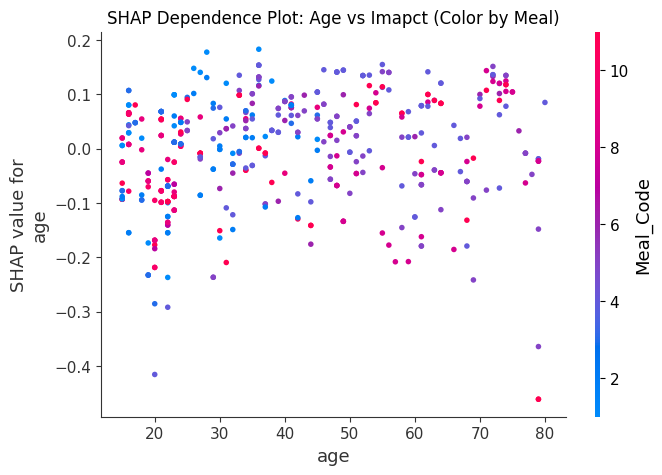

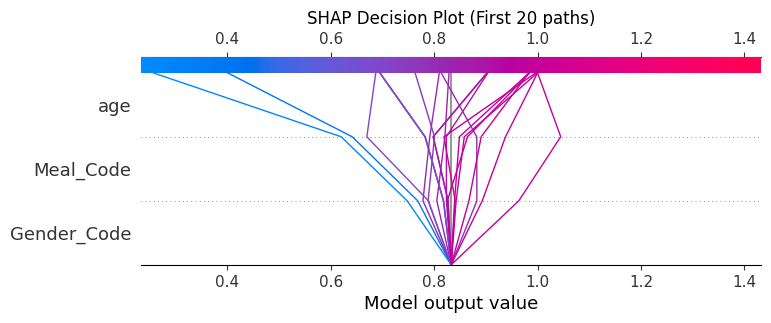

In [21]:
# Explain feature importance using the modern SHAP API
# Creating a generic Explainer for cleaner API usage
explainer = shap.Explainer(clf, X_train)
# shap_values_obj will be an Explanation object containing .values, .base_values, .data
shap_values_obj = explainer(X_test)

# For binary classification, shap_values_obj has structure (n_samples, n_features, n_classes)
# We focus on the positive class (index 1) which represents Sentiment=1
# Slicing acts on the Explanation object itself
vals = shap_values_obj[..., 1]

print("--- 5. Advanced SHAP Analysis ---")

# 1. Beeswarm Plot (Upgrade from Summary Plot)
# Shows distribution of Shapley values for each feature
plt.figure()
plt.title("SHAP Beeswarm Plot (Global Feature Importance)")
shap.plots.beeswarm(vals, show=True)

# 2. Bar Plot (Absolute Mean Importance)
plt.figure()
plt.title("SHAP Bar Plot (Mean Absolute Impact)")
shap.plots.bar(vals, show=True)

# 3. Waterfall Plot (Local Instance Explanation)
# Explains how each feature contributed to moving the prediction from the base value to the final score
instance_idx = 0
print(f"\nWaterfall for instance {instance_idx}:")
plt.figure()
plt.title(f"SHAP Waterfall Plot for Instance {instance_idx}")
shap.plots.waterfall(vals[instance_idx], show=True)

# 4. Heatmap Plot (Instance Clustering)
# Shows patterns of explanation similarity across samples
plt.figure()
plt.title("SHAP Heatmap (Top 100 Samples)")
shap.plots.heatmap(vals[:100], show=True)

# 5. Dependence Plot (Feature Interactions)
# Shows how "Age" effect varies, colored by "Meal_Code" interaction
# Note: dependence_plot uses raw matplotlib/legacy API, so we pass .values and raw X matrix
plt.figure()
shap.dependence_plot("age", vals.values, X_test, interaction_index="Meal_Code", show=False)
plt.title("SHAP Dependence Plot: Age vs Imapct (Color by Meal)")
plt.show()

# 6. Decision Plot (Prediction Path)
# Visualizes the cumulative effect of features for a group of samples
plt.figure()
plt.title("SHAP Decision Plot (First 20 paths)")
# Need base value (expected value) for the positive class
expected_value = explainer.expected_value[1]
shap.decision_plot(expected_value, vals.values[:20], X_test.iloc[:20], show=True)


## 5. Advanced LIME Analysis

In [22]:
# Using SP-LIME (Submodular Pick) to find representative instances
# This selects a diverse set of instances that cover important feature behaviors
import warnings
warnings.filterwarnings('ignore') # Suppress LIME warnings

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=['Age', 'Gender', 'Meal_Category'],
    class_names=['Negative', 'Positive'],
    mode='classification',
    discretize_continuous=True
)

# Explain one instance with detailed visualization
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[0].values, 
    predict_fn=clf.predict_proba, 
    num_features=5
)
print("LIME Explanation for Instance 0 (List):")
print(exp.as_list())
# In a real notebook, exp.show_in_notebook() creates an HTML visualization
exp.show_in_notebook(show_table=True, show_all=False)

LIME Explanation for Instance 0 (List):
[('Age <= 23.00', -0.11742507933394727), ('0.00 < Gender <= 1.00', 0.02115877109142954), ('Meal_Category <= 3.00', 0.007442684707983928)]
